In [1]:
from nilearn import datasets
n_samples = 94
localizer_dataset = datasets.fetch_localizer_contrasts(
    ['left button press (auditory cue)'],
    n_subjects=n_samples, legacy_format=False
)

In [2]:
print(f'First contrast nifti image (3D) is located at: {localizer_dataset.cmaps[0]}')

First contrast nifti image (3D) is located at: /home/k1812017/nilearn_data/brainomics_localizer/brainomics_data/S01/cmaps_LeftAuditoryClick.nii.gz


In [3]:
tested_var = localizer_dataset.ext_vars['pseudo']
print(tested_var)

0     15.0
1     16.0
2     14.0
3     19.0
4     16.0
      ... 
89    12.0
90    16.0
91    13.0
92    25.0
93    21.0
Name: pseudo, Length: 94, dtype: float64


In [4]:
import numpy as np
mask_quality_check = np.where(
    np.logical_not(np.isnan(tested_var))
)[0]
n_samples = mask_quality_check.size
contrast_map_filenames = [localizer_dataset.cmaps[i]
                          for i in mask_quality_check]
tested_var = tested_var[mask_quality_check].values.reshape((-1, 1))
print(f"Actual number of subjects after quality check: {n_samples}")

Actual number of subjects after quality check: 89


In [5]:
import pandas as pd
design_matrix = pd.DataFrame(
    np.hstack((tested_var, np.ones_like(tested_var))),
    columns=['fluency', 'intercept'])

In [6]:
from nilearn.glm.second_level import SecondLevelModel
model = SecondLevelModel(smoothing_fwhm=5.0)
model.fit(contrast_map_filenames, design_matrix=design_matrix)

/home/k1812017/envs/neuroimaging/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


SecondLevelModel(smoothing_fwhm=5.0)

In [8]:
z_map = model.compute_contrast('fluency', output_type='z_score')

In [9]:
from nilearn.glm import threshold_stats_img
_, threshold = threshold_stats_img(z_map, alpha=.05, height_control='fdr')

/home/k1812017/envs/neuroimaging/lib/python3.9/site-packages/nilearn/plotting/img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


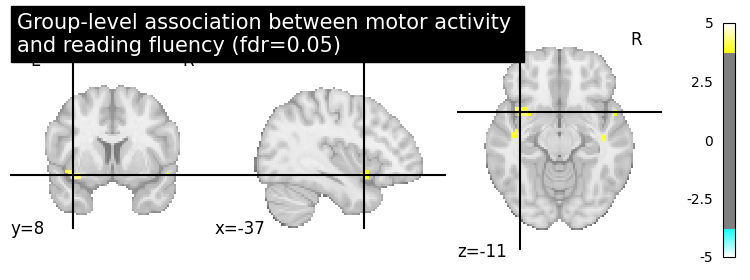

In [10]:
from nilearn import plotting
plotting.plot_stat_map(
    z_map, threshold=threshold, colorbar=True,
    title='Group-level association between motor activity \n'
    'and reading fluency (fdr=0.05)')

plotting.show()

In [11]:
from nilearn.image import math_img
from nilearn.image import get_data

p_val = model.compute_contrast('fluency', output_type='p_value')
n_voxels = np.sum(get_data(model.masker_.mask_img_))
# Correcting the p-values for multiple testing and taking negative logarithm
neg_log_pval = math_img("-np.log10(np.minimum(1, img * {}))"
                        .format(str(n_voxels)),
                        img=p_val)

<string>:1: RuntimeWarning: divide by zero encountered in log10


/home/k1812017/envs/neuroimaging/lib/python3.9/site-packages/nilearn/_utils/niimg.py:63: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


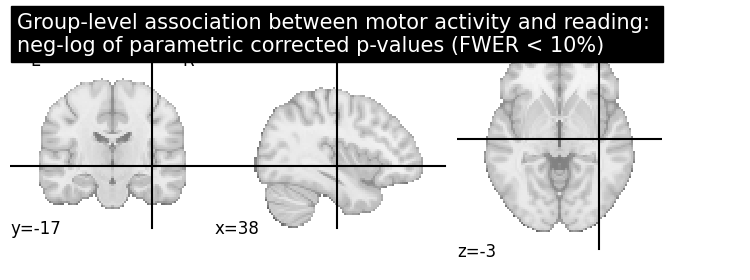

In [12]:
cut_coords = [38, -17, -3]
# Since we are plotting negative log p-values and using a threshold equal to 1,
# it corresponds to corrected p-values lower than 10%, meaning that there
# is less than 10% probability to make a single false discovery
# (90% chance that we make no false discoveries at all).
# This threshold is much more conservative than the previous one.
threshold = 1
title = ('Group-level association between motor activity and reading: \n'
         'neg-log of parametric corrected p-values (FWER < 10%)')
plotting.plot_stat_map(neg_log_pval, colorbar=True, cut_coords=cut_coords,
                       threshold=threshold, title=title)
plotting.show()

<AxesSubplot: label='conditions', ylabel='scan number'>

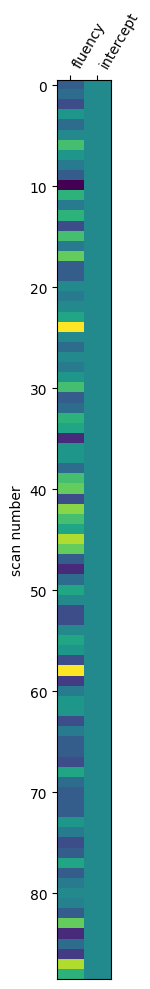

In [15]:
from nilearn.plotting import plot_design_matrix
plot_design_matrix(design_matrix)

In [8]:
from nilearn.glm.second_level import non_parametric_inference
neg_log_pvals_permuted_ols_unmasked = \
    non_parametric_inference(contrast_map_filenames,
                             design_matrix=design_matrix,
                             second_level_contrast='fluency',
                             model_intercept=True, n_perm=1000,
                             two_sided_test=False, mask=None,
                             smoothing_fwhm=5.0, n_jobs=1)

/home/k1812017/envs/neuroimaging/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


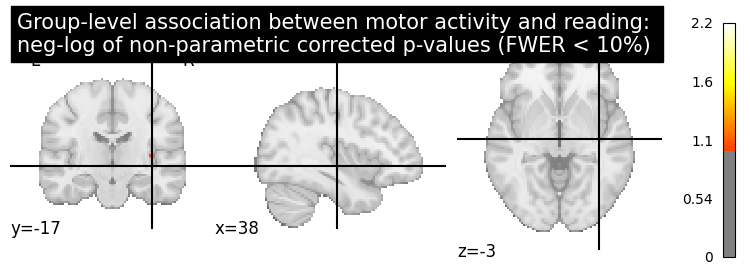

In [14]:
title = ('Group-level association between motor activity and reading: \n'
         'neg-log of non-parametric corrected p-values (FWER < 10%)')
plotting.plot_stat_map(neg_log_pvals_permuted_ols_unmasked, colorbar=True,
                       cut_coords=cut_coords, threshold=threshold,
                       title=title)
plotting.show()